# Summary of Allreduce within a Node

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 20)

project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/intra_anode'
dir_vnode_results = f'{project_dir}/intra_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            column_key = f'{method}:{node}'
            file_pattern = f'{dirpath}/job.sh.*.{suffix}'
            files = glob.glob(file_pattern)
            if not files:
                continue
            data = read_data_from_file(files[0], column_key)
            series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode,mpi-gpu:vnode,mpi-cpu:anode,mpi-cpu:vnode,nccl:anode,nccl:vnode
4,30.23,24.94,1.81,1.73,17.18,8.49
8,29.99,24.68,1.76,1.72,16.94,8.22
16,30.71,25.28,1.74,1.71,17.11,8.21
32,30.90,25.59,2.01,2.07,17.24,8.24
64,30.71,25.60,1.91,2.23,17.42,8.33
128,31.51,26.24,2.69,2.38,17.48,8.55
256,33.98,26.38,2.88,2.50,18.20,8.52
512,32.30,26.81,3.24,2.74,18.47,8.75
1024,33.19,27.48,3.58,3.26,19.83,9.47
2048,35.31,29.92,4.87,4.61,22.37,10.48


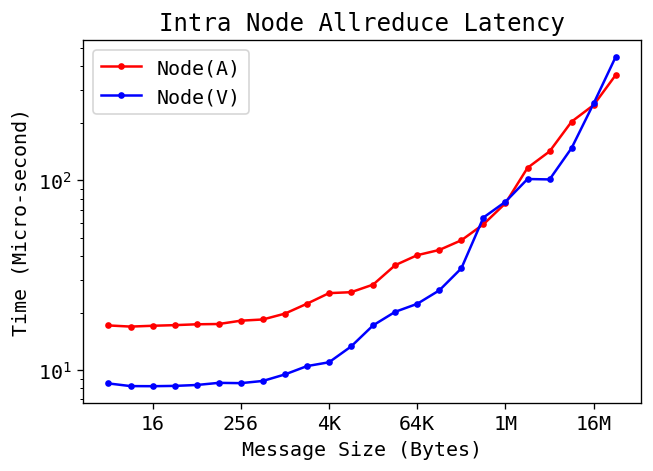

In [4]:
title = 'Intra Node Allreduce Latency'
column_labels = {
    'nccl:anode': 'Node(A)',
    'nccl:vnode': 'Node(V)',
}
markers = ['r.-', 'b.-']
plot(data, column_labels, markers, title)

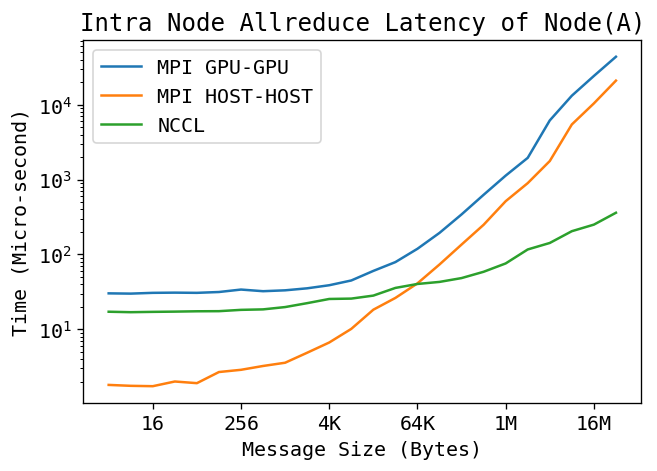

In [5]:
title = 'Intra Node Allreduce Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode': 'MPI GPU-GPU',
    'mpi-cpu:anode': 'MPI HOST-HOST',
    'nccl:anode': 'NCCL',
}
markers = []
plot(data, column_labels, markers, title)

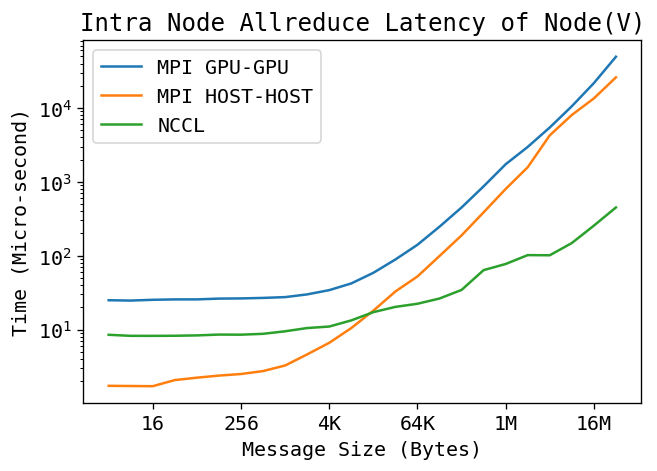

In [6]:
title = 'Intra Node Allreduce Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode': 'MPI GPU-GPU',
    'mpi-cpu:vnode': 'MPI HOST-HOST',
    'nccl:vnode': 'NCCL',
}
markers = []
plot(data, column_labels, markers, title)